Train Regression (3 CLIP scores -> T) Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


(485, 2)


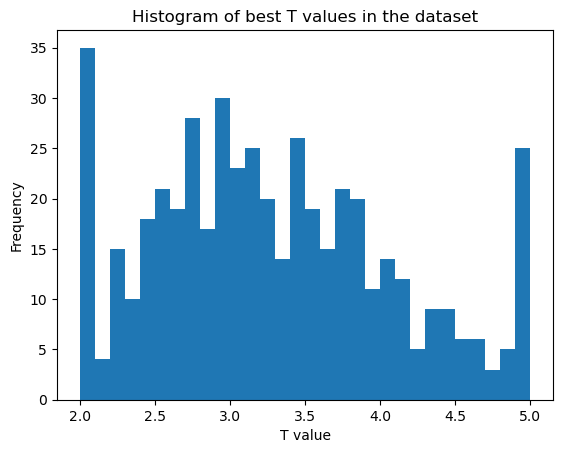

In [15]:
save_path = Path('/home/soom/CLODE/soom_npy_results')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
results = np.load(save_path / 'results.npy')
print(results.shape)

# relative frequency of best T values in the dataset: histogram
best_T_values = results[:, 0]
plt.hist(best_T_values, bins=30)
plt.xlabel('T value')
plt.ylabel('Frequency')
plt.title('Histogram of best T values in the dataset')
plt.show()

In [16]:
from misc import *

file_path = Path('/home/soom/data/our485')
img_labels = sorted(os.listdir(file_path / 'low'))

def load_image(idx):
    lq_img = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
    gt_img = image_tensor(file_path / 'high' / img_labels[idx], size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device)

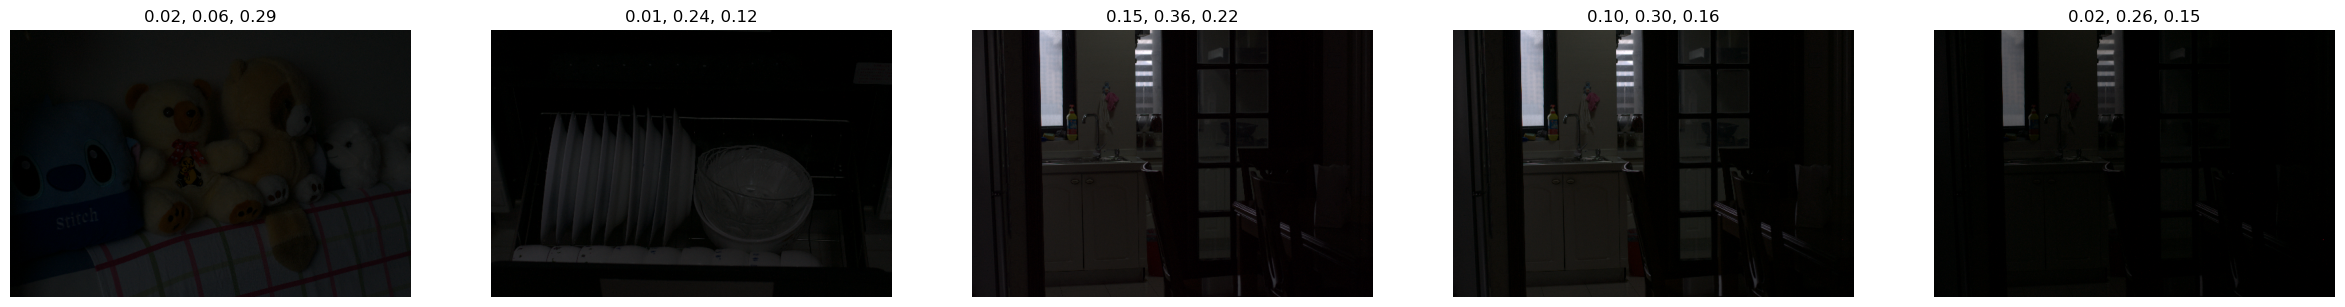

In [17]:
from torchmetrics.multimodal import CLIPImageQualityAssessment

prompts = ('brightness', 'noisiness', 'quality')
clip_iqa = CLIPImageQualityAssessment(prompts=prompts).to(device)

fig, axes = plt.subplots(1, 5, figsize=(30, 6))

for idx in range(5):
    lq_img = Image.open(file_path / 'low' / img_labels[idx])
    lq_t = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
    scores = clip_iqa(lq_t)
    
    # display images and corresponding scores
    axes[idx].imshow(lq_img)
    axes[idx].set_title(f'{scores["brightness"].item():.2f}, {scores["noisiness"].item():.2f}, {scores["quality"].item():.2f}')
    axes[idx].axis('off')

plt.show()


In [ ]:
class CLIPScoreDataset(Dataset):
    def __init__(self, results, device = 'cuda:0'):
        scores = []
        for idx in range(len(results)):
            lq_t = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
            clip_pred = clip_iqa(lq_t)
            scores.append([clip_pred[prompt].item() for prompt in prompts])

        self.scores = torch.tensor(scores, dtype=torch.float32).to(device)
        self.gt_T = torch.tensor(results[:, 0], dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.gt_T)

    def __getitem__(self, idx):
        return self.scores[idx], self.gt_T[idx]

In [28]:
dt_loader = DataLoader(CLIPScoreDataset(results), batch_size=32, shuffle=True)
print(dt_loader.dataset.scores.shape)
print(dt_loader.dataset.gt_T.shape)

print(dt_loader.dataset.scores[0], dt_loader.dataset.gt_T[0])

torch.Size([485, 3])
torch.Size([485])
tensor([0.0229, 0.0649, 0.2945], device='cuda:0') tensor(3.0345, device='cuda:0')


In [29]:
class CLIPtoTRegressor(nn.Module):
    def __init__(self):
        super(CLIPtoTRegressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.mlp(x)
        return 3.5 + 1.5 * out

In [33]:
num_epochs = 1000
learning_rate = 1e-3

model = CLIPtoTRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
model.train()

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    
    for scores, gt_T in dt_loader:
        pred_T = model(scores)
        loss = criterion(pred_T, gt_T)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(dt_loader))
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}')

 10%|█         | 102/1000 [00:05<00:48, 18.38it/s]

Epoch 100/1000, Loss: 0.6851


 20%|██        | 202/1000 [00:10<00:41, 19.29it/s]

Epoch 200/1000, Loss: 0.6866


 30%|███       | 303/1000 [00:15<00:35, 19.37it/s]

Epoch 300/1000, Loss: 0.7109


 40%|████      | 403/1000 [00:21<00:31, 19.22it/s]

Epoch 400/1000, Loss: 0.6563


 50%|█████     | 503/1000 [00:26<00:25, 19.35it/s]

Epoch 500/1000, Loss: 0.7154


 60%|██████    | 603/1000 [00:31<00:20, 19.31it/s]

Epoch 600/1000, Loss: 0.6799


 70%|███████   | 703/1000 [00:36<00:15, 19.37it/s]

Epoch 700/1000, Loss: 0.6751


 80%|████████  | 803/1000 [00:41<00:10, 19.35it/s]

Epoch 800/1000, Loss: 0.6918


 90%|█████████ | 903/1000 [00:46<00:05, 19.31it/s]

Epoch 900/1000, Loss: 0.6483


100%|██████████| 1000/1000 [00:51<00:00, 19.25it/s]

Epoch 1000/1000, Loss: 0.6693


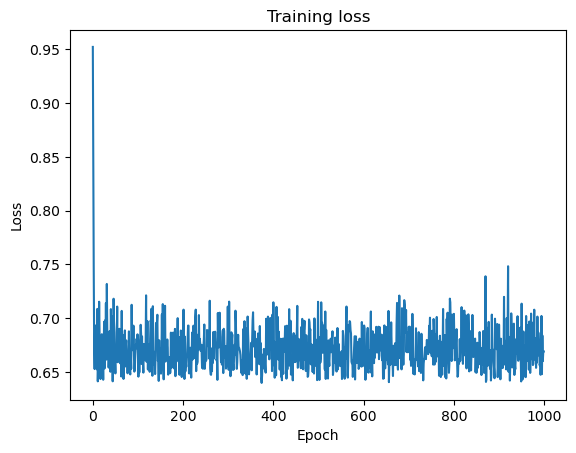

In [34]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

Evaluate Regression model

In [39]:
eval_path = Path('/home/soom/data/eval15')
img_labels = sorted(os.listdir(eval_path / 'low'))

def load_image(idx, dir=eval_path):
    lq_img = image_tensor(dir / 'low' / img_labels[idx], size=(256, 256))
    gt_img = image_tensor(dir / 'high' / img_labels[idx], size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device)

print(len(img_labels))

15


In [40]:
from network.conv_node import NODE

clode = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
clode.eval()
clode.to(device)
clode.load_state_dict(torch.load(f'pth/universal.pth', weights_only=True), strict=False)

T_values = np.linspace(2, 5, 30)

eval_gt = []
with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        lq_img, gt_img = load_image(idx)

        high_psnr = 0.0
        best_T = 2.0
        for T in tqdm(T_values, leave=False):
            integration_time = torch.tensor([0, T]).float().cuda()
            pred = clode(lq_img, integration_time, inference=True)['output'][0]
            
            _psnr = calculate_psnr(pred, gt_img).item()
            if high_psnr < _psnr:
                high_psnr = _psnr
                best_T = T
        eval_gt.append([best_T, high_psnr])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [10:41<00:00, 42.76s/it]


In [44]:
# eval_gt 임시 저장
np.save(save_path / 'eval_gt.npy', np.array(eval_gt))

100%|██████████| 15/15 [00:01<00:00, 11.70it/s]


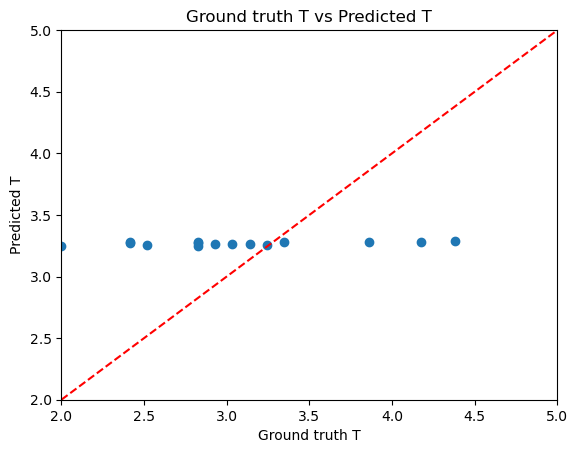

In [42]:
model.eval()

preds = []
for idx in tqdm(range(len(img_labels))):
    lq_img, _ = load_image(idx)
    clip_pred = clip_iqa(lq_img)
    clip_scores = torch.tensor([clip_pred[prompt].item() for prompt in prompts], dtype=torch.float32).to(device)
    
    pred_T = model(clip_scores)
    preds.append(pred_T.item())

plt.scatter([x[0] for x in eval_gt], preds)
plt.xlabel('Ground truth T')
plt.ylabel('Predicted T')
plt.title('Ground truth T vs Predicted T')

plt.xlim(2, 5)
plt.ylim(2, 5)
plt.plot([2, 5], [2, 5], 'r--')
plt.show()

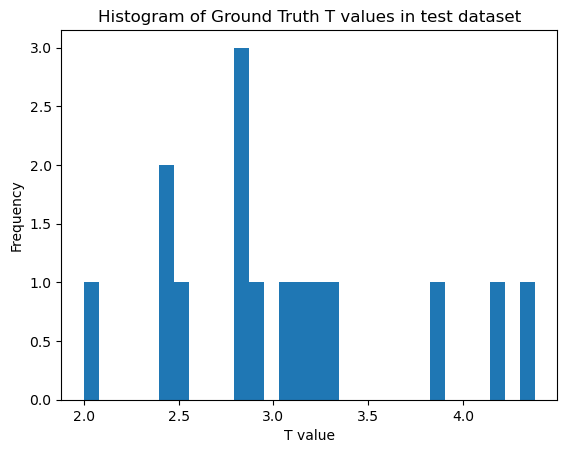

In [43]:
# relative frequency of T values in test dataset: histogram
plt.hist([x[0] for x in eval_gt], bins=30)
plt.xlabel('T value')
plt.ylabel('Frequency')
plt.title('Histogram of Ground Truth T values in test dataset')
plt.show()

Train data에 대해서는 잘 fitting되는지 확인

485


100%|██████████| 485/485 [00:44<00:00, 10.86it/s]


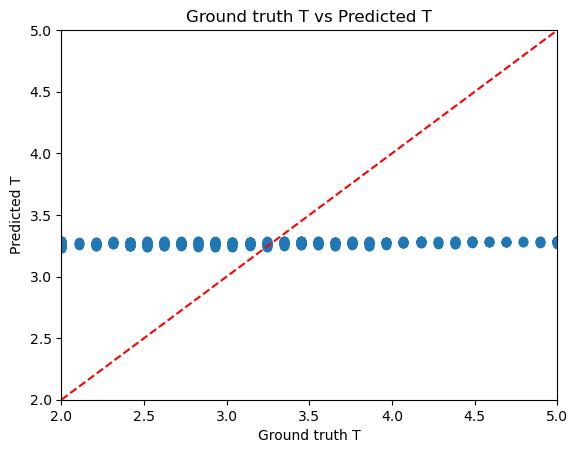

In [45]:
img_labels = sorted(os.listdir(file_path / 'low'))
print(len(img_labels))

model.eval()

preds = []
for idx in tqdm(range(len(img_labels))):
    lq_img, _ = load_image(idx, dir=file_path)
    clip_pred = clip_iqa(lq_img)
    clip_scores = torch.tensor([clip_pred[prompt].item() for prompt in prompts], dtype=torch.float32).to(device)
    
    pred_T = model(clip_scores)
    preds.append(pred_T.item())

plt.scatter(results[:, 0], preds)
plt.xlabel('Ground truth T')
plt.ylabel('Predicted T')
plt.title('Ground truth T vs Predicted T')

plt.xlim(2, 5)
plt.ylim(2, 5)
plt.plot([2, 5], [2, 5], 'r--')
plt.show()